In [13]:
using Pkg
Pkg.instantiate()
using HTTP, JSON, JLD, Roots, PrettyTables, DotEnv
DEBUG_LEVEL = 1
using Optim, Random
Random.seed!(0)
using BlackBoxOptim, Distributions, ForwardDiff, Integrals, Roots, StatsPlots, DelimitedFiles
cfg = DotEnv.config("../.env")
files_path = cfg["files_path"]

"/home/peters/code/mapinator/estimation/current_estimates_and_files/"

In [16]:
raw_placement_rates = load(files_path*"adjusted_placement_rates.jld")["adjusted_placement_rates"]
row_index = 10
adjusted_placement_rates = vcat(raw_placement_rates[1:row_index-1,:],
    raw_placement_rates[row_index+1:size(raw_placement_rates)[1],:])
NUMBER_OF_TYPES = size(adjusted_placement_rates, 2)
numtotal = size(adjusted_placement_rates, 1)
adjusted_placement_rates

11×5 Matrix{Int64}:
 1424   469   326   110   11
 1133  1184   595   232   28
 1280  1917  1869   373   96
  322   703   855  1044   93
    0    58   100    71  459
  678   757   540   145   65
  927   612   436   140   73
  103   180   256   143   76
   41    82   131   105  135
  251   229   157    82   25
  286   523   796   406  194

In [17]:
function F(x, ρ, μ, σ, K)
    return sum([ρ[i] * cdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function f(x, ρ, μ, σ, K)
    return sum([ρ[i] * pdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function G(Fim1, Fx, αsum)
    return (Fim1 - Fx) / αsum
end

function κ(i, t, v_rel)
    return sum([-log(v_rel[j]) for j in t:i-1])
end

function fi(x, μ, σ)
    return pdf(truncated(Normal(μ, σ), 0, 1), x)
end

fi (generic function with 1 method)

In [18]:
function q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    # TODO: can some integrals be cached as a speed-up? can some integrals be computed in parallel?
    return sum([(α[t]/sum(α[1:s])) * solve(IntegralProblem{false}((x, p) -> exp(-(G(Fx_vec[s], F(x, ρ, μ, σ, K), sum(α[1:s])) + κ(s, t, v_rel))) * fi(x, μ[i], σ[i]), x_vec[s+1], x_vec[s]), HCubatureJL())[1] for s in t:k])
end

function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function Q2(ratio, β)
    return β * (1 - exp(-ratio)) / ratio
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

pi (generic function with 1 method)

In [19]:
function estimate_likelihood(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    #β = p_vec[end] # set = 1 to hardcode
    # a guess about how to kill the second round
    β = 0
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    normalizer = 0.0

    q_it = zeros(K, k)
    for i in 1:K
        for t in 1:k
            prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
            q_it[i, t] = prob
            normalizer += ρ[i] * prob
        end
    end

    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    for i in 1:K
        for t in 1:k
            prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
            # println(sum([q_it[i, s] for s in 1:k]))
            # println(t, " ", i, " ", ρ[i] * (q_it[i, t] + prob), " ", ρ[i], " ", q_it[i, t], " ", (1 - sum([q_it[i, s] for s in 1:k])), " ", Q2(D/S, β), " ", α[t], " ", (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])), " ", S, " ", prob)
            objective += placements[i, t] * (log(ρ[i] * (q_it[i, t] + prob)))
            normalizer += ρ[i] * prob
        end
    end
    
    objective -= M * log(normalizer)
    return -objective
end

function print_metrics_maximum_likelihood(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    β = p_vec[end] # set = 1 to hardcode

    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    likelihood = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
        q_it[i, t] = prob
        normalizer += ρ[i] * prob
    end
    
    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    round_2 = zeros(K, k)
    round_2_hiring = zeros(K, k)

    for i in 1:K, t in 1:k
        prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        round_2[i, t] = prob
        round_2_hiring[i, t] = Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    exp_placements_round_1 = zeros(K, k)
    exp_placements_round_2 = zeros(K, k)
    exp_placements = zeros(K, k)
    for i in 1:K, t in 1:k 
        expectation = M * (ρ[i] * (q_it[i, t] + round_2[i, t]) / normalizer)
        exp_placements_round_1[i, t] = M * (ρ[i] * q_it[i, t] / normalizer)
        exp_placements_round_2[i, t] = M * (ρ[i] * round_2[i, t] / normalizer)
        exp_placements[i, t] = expectation
        objective += (placements[i, t] - expectation) ^ 2 / expectation
        likelihood += placements[i, t] * (log(ρ[i] * (q_it[i, t] + round_2[i, t])))
        likelihood -= log(factorial(big(placements[i, t])))
    end
    likelihood -= M * log(normalizer)

    println("chi-square objective value = ", objective)
    println("log-likelihood objective value = ", likelihood)
    println("likelihood objective value = ", exp(likelihood))
    println("success sample size (departments) = ", M)
    println("estimated total samples (departments) = ", M / normalizer)
    println("estimated unmatched departments = ", (M / normalizer) - M)
    println("probability of any success: ", normalizer)
    println("probability of no success: ", 1 - normalizer)
    println("measure of departments in round 2 = ", D)
    println("measure of graduates in round 2 = ", S)
    println()
    println("predicted fraction of departments of each tier:")
    display(ρ)
    println()
    println("fractions observed among successful departments in data:")
    display(sum(placements, dims = 2) ./ M)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Round 1 hiring probabilities:")
    display(q_it)
    println()

    println("Probabilities of failing round 1")
    display(round_1_failure)
    println()

    println("Probabilities of failing round 1 and hiring in round 2:")
    display(round_2)
    println()

    println("Round 2 hiring probabilities:")
    display(round_2_hiring)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (M / normalizer - 1))
        println("  Successful: ", sum(placements[:, i]))
        println("  Unsuccessful: ", (α[i] * (M / normalizer - 1)) - sum(placements[:, i]))
    end
    println("Total estimated graduates: ", sum(α) * (M / normalizer - 1))
    println("Total successful graduates: ", M)
    println("Total estimated unsuccessful graduates: ", (sum(α) * (M / normalizer - 1)) - M)
    println("β = ", β)
    println()
    println("estimated placement rates, round 1 only:")
    display(exp_placements_round_1)
    println()
    println("estimated placement rates, round 2 only:")
    display(exp_placements_round_2)
    println()
    println("estimated placement rates, cumulative:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective))
end

print_metrics_maximum_likelihood (generic function with 1 method)

In [20]:
k = NUMBER_OF_TYPES
K = numtotal
M = sum(adjusted_placement_rates)

# upper bound on the value ratios, which should all be less than 1
# if any ratio turns out to be 1.0 or close to it at optimality, this could indicate that a lower tier has a higher value than a higher one
upper = [1.0 for _ in 1:k-1] 

# upper bound on variables proportionate to alpha
append!(upper, [1.0 for _ in 1:k])

# upper bound on the mu parameter of truncated normal, which is strictly within [0, 1] as the mean is greater than mu in truncated normal
append!(upper, [1.0 for _ in 1:K])

# upper bound on the sigma parameter of truncated normal
append!(upper, [5.0 for _ in 1:K])

# upper bound on variables proportionate to rho
append!(upper, [1.0 for _ in 1:K])

# upper bound on beta friction parameter
push!(upper, 1.0)

# all lower bounds are zero as these should be positive parameters
# can swap estimate_likelihood for chi_square
sol_res = bboptimize(p -> estimate_likelihood(p, adjusted_placement_rates, k, K, M), SearchRange = [(0.0, upper[i]) for i in eachindex(upper)], MaxFuncEvals = 100000, TraceInterval = 5)
sol = best_candidate(sol_res)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.00 secs, 1147 evals, 1083 steps, improv/step: 0.416 (last = 0.4164), fitness=88650.220253364
10.01 secs, 2361 evals, 2297 steps, improv/step: 0.318 (last = 0.2298), fitness=86638.608403494
15.01 secs, 3549 evals, 3485 steps, improv/step: 0.273 (last = 0.1869), fitness=86056.983076580
20.02 secs, 4762 evals, 4698 steps, improv/step: 0.248 (last = 0.1739), fitness=85078.247121633
25.02 secs, 5799 evals, 5735 steps, improv/step: 0.231 (last = 0.1562), fitness=84639.312040989
30.03 secs, 6786 evals, 6722 steps, improv/step: 0.222 (last = 0.1662), fitness=84141.434769748
35.03 secs, 7636 evals, 7571 steps, improv/step: 0.215 (last = 0.1625), fitness=84141.434769748
40.03 secs, 8517 evals, 8449 steps, improv/step: 0.211 (last = 0.1811), fitness=83864.063818795
45.04 secs, 9438 evals, 9370 

43-element Vector{Float64}:
 0.5647769732486636
 0.704735463207759
 0.6064775794692105
 0.5829784876670854
 0.5934606758622558
 0.6951713869623724
 0.7302232360932975
 0.4849754486147648
 0.999365560197962
 0.9821133942632663
 0.48309802091683884
 0.40022937346721216
 0.16354345600103548
 ⋮
 0.34944361434062937
 0.5323198554507517
 0.9982483485609558
 0.7423605077257087
 0.15153845470544908
 0.38514923656743694
 0.37001209744224256
 0.15983429705014815
 0.11191543271331203
 0.13034462590938828
 0.4624349418246976
 0.4533614153844223

In [21]:
# uncomment this after estimation if you want detailed estimates

# ensure the correct metrics function is used based on the selected optimizer
print_metrics_maximum_likelihood(sol, adjusted_placement_rates, k, K, M)


chi-square objective value = 1605.2121296846967
log-likelihood objective value = -212519.8123602349566516382044687163048712036260932882971482376970995148605134987
likelihood objective value = 6.579559754433610405578133785389063615831344752127362254325014377805935739795072e-92297
success sample size (departments) = 23326
estimated total samples (departments) = 33330.595080884406
estimated unmatched departments = 10004.595080884406
probability of any success: 0.6998374899516213
probability of no success: 0.3001625100483787
measure of departments in round 2 = 0.46461506595039814
measure of graduates in round 2 = 0.8981665425917995

predicted fraction of departments of each tier:


11-element Vector{Float64}:
 0.07953466451533156
 0.12115797622461448
 0.22720503179201518
 0.16896400880813162
 0.034490715129855284
 0.08766139675074194
 0.08421612766400832
 0.03637887965963993
 0.025472368157984992
 0.029666920978484862
 0.10525191031919186


fractions observed among successful departments in data:


11×1 Matrix{Float64}:
 0.10031724256194804
 0.1359855954728629
 0.23728886221383863
 0.12934064991854582
 0.029494984137871903
 0.09367229700763097
 0.09380090885706936
 0.032495927291434454
 0.021178084540855697
 0.03189573866072194
 0.09452970933722027


pi_1 = 1.0
pi_2 = 0.5394646051554742
pi_3 = 0.3617016219462017
pi_4 = 0.19369338326588822
pi_5 = 0.28527249757389256

Tier selection probabilities for making offers:


5×5 Matrix{Float64}:
 1.0       0.0       0.0       0.0       0.0
 0.460535  0.539465  0.0       0.0       0.0
 0.293959  0.344339  0.361702  0.0       0.0
 0.237021  0.277643  0.291642  0.193693  0.0
 0.169405  0.198439  0.208445  0.138438  0.285272


Round 1 hiring probabilities:


11×5 Matrix{Float64}:
 0.400011    0.156085   0.0861454  0.0218444  0.00891343
 0.218295    0.203632   0.140599   0.0315726  0.00817309
 0.128151    0.200737   0.180429   0.0430115  0.00820484
 0.0412099   0.0854722  0.127398   0.138991   0.012712
 1.13416e-9  0.0456702  0.0680724  0.0745453  0.263495
 0.180607    0.189799   0.149082   0.0426405  0.0143899
 0.254651    0.166981   0.120425   0.0403421  0.0198072
 0.0652844   0.124166   0.155761   0.0871884  0.050447
 0.0367991   0.0763147  0.113348   0.107289   0.108902
 0.195003    0.166978   0.134925   0.0495338  0.0251341
 0.0605289   0.122577   0.164183   0.0908041  0.0401471


Probabilities of failing round 1


11-element Vector{Float64}:
 0.32700051233081795
 0.39772949388688794
 0.43946725060535696
 0.5942164367283207
 0.5482171382612194
 0.42348043328483076
 0.3977938692493116
 0.5171539085205442
 0.5573471401932305
 0.4284261739101164
 0.5217602586355776


Probabilities of failing round 1 and hiring in round 2:


11×5 Matrix{Float64}:
 0.0186196  0.021641   0.0230525  0.0166722  0.035758
 0.0226469  0.0263218  0.0280387  0.0202783  0.0434924
 0.0250235  0.029084   0.030981   0.0224064  0.0480564
 0.033835   0.0393254  0.0418904  0.0302963  0.0649785
 0.0312158  0.0362811  0.0386475  0.027951   0.0599484
 0.0241132  0.028026   0.029854   0.0215913  0.0463083
 0.0226506  0.0263261  0.0280432  0.0202816  0.0434994
 0.029447   0.0342253  0.0364577  0.0263672  0.0565516
 0.0317357  0.0368853  0.0392912  0.0284165  0.0609468
 0.0243948  0.0283533  0.0302027  0.0218434  0.0468491
 0.0297093  0.0345302  0.0367824  0.0266021  0.0570553


Round 2 hiring probabilities:


11×5 Matrix{Float64}:
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352
 0.0569406  0.0661802  0.0704968  0.0509853  0.109352


x_0 = 1.0
x_1 = 0.7170609448111136
x_2 = 0.5448555026089719
x_3 = 0.29889393491616983
x_4 = 0.08369598727409548
x_5 = 0.0

F(x_0) = 1.0
F(x_1) = 0.9032145181020219
F(x_2) = 0.7744936142540041
F(x_3) = 0.4862984211591156
F(x_4) = 0.1006278924422841

α_1 = 0.1694054867986247
  Est. graduates: 5646.21627947827
  Successful: 6445
  Unsuccessful: -798.7837205217302
α_2 = 0.19843917551189125
  Est. graduates: 6613.897367995888
  Successful: 6714
  Unsuccessful: -100.10263200411191
α_3 = 0.2084448520575004
  Est. graduates: 6947.382515771344
  Successful: 6061
  Unsuccessful: 886.3825157713436
α_4 = 0.13843798805809107
  Est. graduates: 4614.082085788486
  Successful: 2851
  Unsuccessful: 1763.0820857884864
α_5 = 0.28527249757389256
  Est. graduates: 9508.016831850418
  Successful: 1255
  Unsuccessful: 8253.016831850418
Total estimated graduates: 33329.595080884406
Total successful graduates: 23326
Total estimated unsuccessful graduates: 10003.595080884406
β = 0.4533614153844223

estimated p

11×5 Matrix{Float64}:
 1060.4          413.772    228.366    57.9082   23.629
  881.532        822.319    567.775   127.499    33.0051
  970.47        1520.15    1366.37    325.721    62.1343
  232.081        481.351    717.464   782.754    71.5899
    1.30382e-6    52.5023    78.2557   85.697   302.913
  527.7          554.557    435.59    124.587    42.0446
  714.799        468.711    338.029   113.239    55.5984
   79.1593       150.555    188.864   105.718    61.1685
   31.2428        64.7919    96.2331   91.0896   92.459
  192.822        165.11     133.416    48.9798   24.853
  212.342        430.013    575.971   318.551   140.84


estimated placement rates, round 2 only:


11×5 Matrix{Float64}:
  49.3594   57.3688   61.1107   44.197    94.7923
  91.4544  106.295   113.228    81.8894  175.634
 189.5     220.25    234.616   169.681   363.926
 190.548   221.467   235.913   170.619   365.938
  35.8856   41.7086   44.4291   32.1324   68.9165
  70.4542   81.8866   87.2276   63.0855  135.304
  63.5797   73.8966   78.7165   56.93    122.102
  35.7054   41.4992   44.206    31.9711   68.5705
  26.9439   31.316    33.3586   24.1259   51.7444
  24.122    28.0362   29.8649   21.5991   46.3251
 104.224   121.136   129.037    93.323   200.156


estimated placement rates, cumulative:


11×5 Matrix{Float64}:
 1109.76     471.141    289.477  102.105  118.421
  972.986    928.613    681.003  209.388  208.639
 1159.97    1740.4     1600.98   495.401  426.06
  422.629    702.819    953.376  953.373  437.528
   35.8856    94.2109   122.685  117.829  371.829
  598.154    636.444    522.817  187.673  177.348
  778.378    542.608    416.746  170.169  177.7
  114.865    192.054    233.07   137.69   129.739
   58.1866    96.1079   129.592  115.215  144.203
  216.944    193.146    163.281   70.579   71.1782
  316.565    551.149    705.008  411.874  340.997


actual placement rates:


11×5 Matrix{Int64}:
 1424   469   326   110   11
 1133  1184   595   232   28
 1280  1917  1869   373   96
  322   703   855  1044   93
    0    58   100    71  459
  678   757   540   145   65
  927   612   436   140   73
  103   180   256   143   76
   41    82   131   105  135
  251   229   157    82   25
  286   523   796   406  194


difference between estimated and actual placement rates:


11×5 Matrix{Float64}:
 -314.236      2.14065    -36.5231    -7.89484  107.421
 -160.014   -255.387       86.0025   -22.6121   180.639
 -120.03    -176.596     -268.018    122.401    330.06
  100.629     -0.181158    98.3763   -90.6275   344.528
   35.8856    36.2109      22.6848    46.8293   -87.1708
  -79.846   -120.556      -17.1826    42.6729   112.348
 -148.622    -69.3923     -19.2544    30.1692   104.7
   11.8647    12.0539     -22.9296    -5.31047   53.739
   17.1866    14.1079      -1.4083    10.2154     9.2034
  -34.0561   -35.8536       6.28136  -11.421     46.1782
   30.5654    28.1487     -90.9923     5.87385  146.997


chi-square p-value
0.0


In [22]:
v_base = 1
type_values = []
type_headers = []
row_names = ["Graduate Values"]
for i in 1:k
 #   println("v", i, ": ", v_base)
    push!(type_values, v_base)
    push!(type_headers, string("Tier ", i))
    if i != k
        v_base = sol[i] * v_base
    end
end
data = Vector{Float64}(type_values)
head = Vector{String}(type_headers)
#println(size(data,2), " " , size(data,1))
#println(Vector{String}(type_headers))
#println(row_names)
#pretty_table(data', header = head, row_names=row_names)
means_by_type = []
std_by_type = []
for select_type in 1:k
    push!(means_by_type, mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0 ,1)))
    push!(std_by_type, std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0 ,1)))
   
    #println("mean for type ", select_type, ": ", mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    #println("stddev for type ", select_type, ": ", std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    #println()
end
datam = Vector{Float64}(means_by_type)
datas = Vector{Float64}(std_by_type)
shares = 1.0 * sol[k:2k-1] / sum(sol[k:2k-1]) # change 1.0 to scale number of graduates vs departments
all_data = hcat(data, datam, datas, shares )
push!(row_names, "Mean offer value")
push!(row_names, "Offers, std deviation")
push!(row_names, "Tier Shares")

#println(all_data)    
pretty_table(all_data', header = head, row_labels=row_names)

#for select_type in k+1:K
#    println("mean for sink ", select_type - k, ": ", mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
#    println("stddev for sink ", select_type - k, ": ", std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
#    println()
#end

┌───────────────────────┬──────────┬──────────┬──────────┬──────────┬─────────────┐
│                       │   Tier 1 │   Tier 2 │   Tier 3 │   Tier 4 │      Tier 5 │
├───────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────┤
│       Graduate Values │      1.0 │ 0.564777 │ 0.398018 │ 0.241389 │    0.140725 │
│      Mean offer value │ 0.607084 │ 0.486908 │ 0.407543 │ 0.163591 │  0.00646005 │
│ Offers, std deviation │ 0.262714 │ 0.219606 │ 0.177966 │ 0.047203 │ 0.000172069 │
│           Tier Shares │ 0.169405 │ 0.198439 │ 0.208445 │ 0.138438 │    0.285272 │
└───────────────────────┴──────────┴──────────┴──────────┴──────────┴─────────────┘


In [23]:
save(files_path*"current_estimates.jld", "all_data", all_data)

In [24]:
open(files_path*"current_estimates.tex", "w") do f
pretty_table(
    f,
    all_data',
    header = head,
        row_labels = row_names,
    backend = Val(:latex)
    )
end

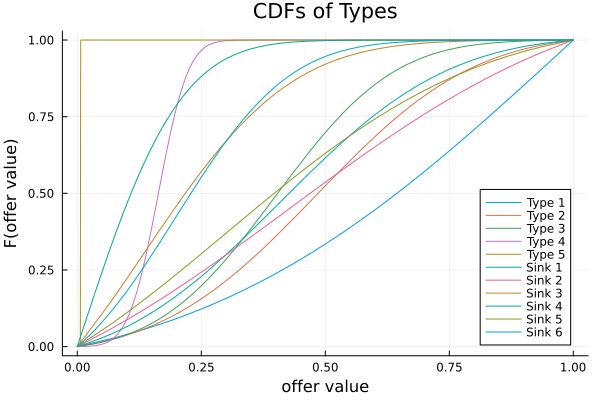

In [25]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/

select_type = 1
cdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Sink ", select_type - k))
end
xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
savefig(cdfs, "cdfs.png")
cdfs

In [36]:
expected_offers = []
for select_type in 1:K
     push!(expected_offers,mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
end
expected_offers
save(files_path*"expected_offers.jld", "expected_offers", expected_offers)

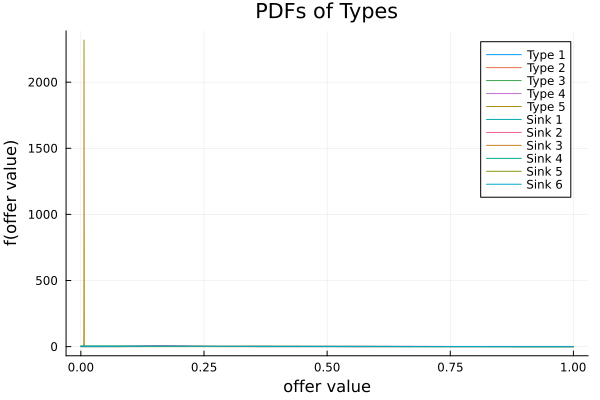

In [30]:
select_type = 1
pdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:k # academic types
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, 
        label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, label = string("Sink ", select_type - k))
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
savefig(pdfs, "pdfs.png")
pdfs